In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import math
import numpy as np
from scipy import stats
import math
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import sys

In [2]:
#read in attributes
labels= gpd.read_file('../../raw-data/project-sidewalk-labels/attributes-230522.json')
labels

,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,avg_image_capture_date,avg_label_date,severity,is_temporary,agree_count,disagree_count,notsure_count,geometry
0,70839935,CurbRamp,14822,98239835,Harbor Island,2017-09-01,2019-04-26 21:46:21.100,3.0,False,1,0,0,POINT (-122.35248 47.58456)
1,70839936,CurbRamp,14822,98239835,Harbor Island,2014-06-01,2019-04-26 04:50:37.138,2.0,False,1,0,0,POINT (-122.35149 47.58473)
2,70839937,CurbRamp,14809,98239825,Harbor Island,2017-09-01,2019-04-22 00:58:33.914,2.0,False,1,0,0,POINT (-122.35236 47.57236)
3,70839938,CurbRamp,14826,98239858,Harbor Island,2017-09-01,2019-04-26 02:03:04.038,2.0,False,1,0,0,POINT (-122.35410 47.57295)
4,70839939,CurbRamp,14826,98239858,Harbor Island,2017-09-01,2019-04-26 11:36:21.207,2.0,False,1,0,1,POINT (-122.35539 47.57450)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105443,77221398,Signal,14586,68307145,Matthews Beach,2022-08-01,2023-05-14 02:42:07.690,NaN,False,0,0,0,POINT (-122.29054 47.71189)
105444,77221399,Signal,1907,6368129,Matthews Beach,2022-09-01,2023-05-09 15:18:32.905,NaN,False,1,1,1,POINT (-122.29060 47.70853)
105445,77221400,Signal,1907,6368129,Matthews Beach,2022-09-01,2023-05-03 09:01:36.253,NaN,False,5,1,0,POINT (-122.29061 47.70829)
105446,77221401,Signal,16959,158794036,Matthews Beach,2022-09-01,2023-04-26 00:26:57.504,NaN,False,2,0,0,POINT (-122.29082 47.70483)


In [3]:
#read in sidewalk data
sidewalk = gpd.read_file('../../raw-data/seattle-sidewalk/Sidewalks/Sidewalks.shp')
sidewalk = sidewalk.dropna(subset=['geometry'])

In [4]:
#change labels and sidewalk to crs 2285
labels = labels.to_crs(epsg=2285)
sidewalk = sidewalk.to_crs(epsg=2285)

In [5]:
#take out the label type = curb ramp and no curb ramp
other_labels = labels[(labels['label_type'] != 'CurbRamp') & (labels['label_type'] != 'NoCurbRamp')]
other_labels

,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,avg_image_capture_date,avg_label_date,severity,is_temporary,agree_count,disagree_count,notsure_count,geometry
44,70839979,NoSidewalk,11429,8115489,Harbor Island,2017-07-01,2019-04-26 21:32:47.983,5.0,False,0,0,0,POINT (1264973.333 212935.193)
45,70839980,NoSidewalk,14811,98239834,Harbor Island,2014-06-01,2019-04-17 04:49:06.653,2.0,False,1,0,0,POINT (1264907.723 213046.438)
46,70839981,NoSidewalk,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:29:29.237,5.0,False,0,0,0,POINT (1264947.861 216409.481)
47,70839982,NoSidewalk,20846,332483030,Harbor Island,2017-09-01,2019-04-26 21:25:49.060,5.0,False,0,0,0,POINT (1265455.358 212353.664)
48,70839983,NoSidewalk,20846,332483030,Harbor Island,2017-09-01,2019-04-26 21:26:52.217,5.0,False,0,0,0,POINT (1265286.003 212553.244)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105443,77221398,Signal,14586,68307145,Matthews Beach,2022-08-01,2023-05-14 02:42:07.690,NaN,False,0,0,0,POINT (1281694.232 263072.944)
105444,77221399,Signal,1907,6368129,Matthews Beach,2022-09-01,2023-05-09 15:18:32.905,NaN,False,1,1,1,POINT (1281657.818 261844.741)
105445,77221400,Signal,1907,6368129,Matthews Beach,2022-09-01,2023-05-03 09:01:36.253,NaN,False,5,1,0,POINT (1281652.402 261757.165)
105446,77221401,Signal,16959,158794036,Matthews Beach,2022-09-01,2023-04-26 00:26:57.504,NaN,False,2,0,0,POINT (1281577.843 260499.068)


In [6]:
labels_mapped_on_sidewalk = other_labels.sjoin_nearest(sidewalk, distance_col='distance', max_distance = 30)
labels_mapped_on_sidewalk

,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,avg_image_capture_date,avg_label_date,severity,is_temporary,agree_count,disagree_count,notsure_count,geometry,index_right,OBJECTID,COMPKEY,COMPTYPE,SEGKEY,UNITID,UNITTYPE,UNITDESC,ADDBY,ADDDTTM,ASBLT,CONDITION,CONDITION_,CURBTYPE,CURRENT_ST,CURRENT__1,FILLERTYPE,FILLERWID,INSTALL_DA,SW_WIDTH,MAINTAINED,MATL,MODBY,MODDTTM,OWNERSHIP,SIDE,SURFTYPE,BUILDERCD,MAINTBYRDW,SWINCOMPLE,MULTIPLESU,GSITYPECD,DATE_MVW_L,PRIMARYDIS,SECONDARYD,OVERRIDEYN,OVERRIDECO,SRTS_SIDEW,PRIMARYCRO,MINIMUMVAR,LAST_VERIF,COLOR,OWNERSHIP_,NATURE_OF_,MAINT_FINA,SW_CATEGOR,VARIABLEWI,MAINTENANC,SHAPE_Leng,distance
46,70839981,NoSidewalk,14825,98239854,Harbor Island,2017-09-01 00:00:00,2019-04-26 22:29:29.237,5.0,False,0,0,0,POINT (1264947.861 216409.481),33688,33689,318276,97,2320,SDW-23395,SDW,16TH AVE SW BETWEEN SW FLORIDA ST AND SW LANDE...,SW DATA LOAD,2007-09-26,None,VERY-POOR,2017-07-06,410C,INSVC,2018-03-20,NONE,0,None,0,None,None,NGOC,2018-03-20,None,W,PCC,None,N,N,N,None,2022-06-17,DISTRICT1,None,N,None,3.0,3.1,0,2017-07-06,None,None,None,None,BLOCK,N,SSRP_SSW3_SWShim,1404.540543,25.438181
116,70840133,Obstacle,14825,98239854,Harbor Island,2017-09-01 00:00:00,2019-04-26 22:28:56.566,3.0,False,3,0,0,POINT (1264958.574 216189.374),33688,33689,318276,97,2320,SDW-23395,SDW,16TH AVE SW BETWEEN SW FLORIDA ST AND SW LANDE...,SW DATA LOAD,2007-09-26,None,VERY-POOR,2017-07-06,410C,INSVC,2018-03-20,NONE,0,None,0,None,None,NGOC,2018-03-20,None,W,PCC,None,N,N,N,None,2022-06-17,DISTRICT1,None,N,None,3.0,3.1,0,2017-07-06,None,None,None,None,BLOCK,N,SSRP_SSW3_SWShim,1404.540543,5.841066
135,70840152,Obstacle,14825,98239854,Harbor Island,2017-09-01 00:00:00,2019-04-26 22:29:06.772,1.0,False,2,1,0,POINT (1264960.527 216288.149),33688,33689,318276,97,2320,SDW-23395,SDW,16TH AVE SW BETWEEN SW FLORIDA ST AND SW LANDE...,SW DATA LOAD,2007-09-26,None,VERY-POOR,2017-07-06,410C,INSVC,2018-03-20,NONE,0,None,0,None,None,NGOC,2018-03-20,None,W,PCC,None,N,N,N,None,2022-06-17,DISTRICT1,None,N,None,3.0,3.1,0,2017-07-06,None,None,None,None,BLOCK,N,SSRP_SSW3_SWShim,1404.540543,6.220040
144,70840161,Obstacle,14825,98239854,Harbor Island,2017-09-01 00:00:00,2019-04-26 22:28:28.039,3.0,False,1,1,0,POINT (1264932.874 216032.616),33688,33689,318276,97,2320,SDW-23395,SDW,16TH AVE SW BETWEEN SW FLORIDA ST AND SW LANDE...,SW DATA LOAD,2007-09-26,None,VERY-POOR,2017-07-06,410C,INSVC,2018-03-20,NONE,0,None,0,None,None,NGOC,2018-03-20,None,W,PCC,None,N,N,N,None,2022-06-17,DISTRICT1,None,N,None,3.0,3.1,0,2017-07-06,None,None,None,None,BLOCK,N,SSRP_SSW3_SWShim,1404.540543,27.833021
48,70839983,NoSidewalk,20846,332483030,Harbor Island,2017-09-01 00:00:00,2019-04-26 21:26:52.217,5.0,False,0,0,0,POINT (1265286.003 212553.244),45059,45067,299451,97,22522,SDW-7282,SDW,KLICKITAT WR AVE SW BETWEEN 16TH WR AVE SW AND...,SW DATA LOAD,2007-09-26,None,None,None,410B,INSVC,None,NONE,0,None,0,None,None,NGOC,2017-07-26,None,SW,UIMPRV,None,N,N,N,None,2022-06-17,DISTRICT1,None,N,None,4.0,0.0,0,None,None,None,None,None,None,N,None,136.773457,1.649602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105431,77221386,Crosswalk,21310,340339043,Matthews Beach,2022-03-01 00:00:00,2023-03-23 00:21:37.150,1.0,False,1,0,0,POINT (1284771.994 257704.099),13327,13328,298066,97,17906,SDW-7936,SDW,NE 95TH ST BETWEEN 45TH AVE NE AND SAND POINT ...,SW DATA LOAD,2007-09-26,None,GOOD,2017-08-14,NONE,INSVC,2007-09-26,AC,36,None,64,None,None,SIDEWALK COLLECTOR,2018-02-07,None,S,AC,None,N,N,N,None,2022-06-17,DISTRICT5,None,N,None,3.0,2.2,0,2017-08-14,None,None,None,None,BLOCK,N,SSRP_NE3_SWShim,563.909910,16.440716
105437,77221392,Crosswalk,1906,6368129,Matthews Beach,2022-09-01 00:00:00,2023-05-09 15:15:26.057,1.0,False,1,0,0,POINT (1281975.925 261777.483),7161

In [7]:
#select attribute_id and OBJECTID
labels_to_sidewalk = labels_mapped_on_sidewalk[['attribute_id', 'OBJECTID']]
labels_to_sidewalk

,attribute_id,OBJECTID
46,70839981,33689
116,70840133,33689
135,70840152,33689
144,70840161,33689
48,70839983,45067
...,...,...
105431,77221386,13328
105437,77221392,7162
105438,77221393,6085
105447,77221402,6085


In [8]:
labels_to_sidewalk['attribute_id'].nunique()


52113

In [9]:
#read in curbs_sidewalk.csv
curbs_to_sidewalk = pd.read_csv('progress-files/curbs_to_sidewalk.csv')
#drop duplicates
curbs_to_sidewalk = curbs_to_sidewalk.drop_duplicates(subset=['attribute_id'])
curbs_to_sidewalk 

,attribute_id,OBJECTID
0,77072222,80
1,77043723,225
2,77111876,372
3,77041931,402
4,77125091,716
...,...,...
40469,77221359,12158
40470,77221365,12118
40471,77221368,7376
40472,77221370,13471


In [10]:
#combine labels_to_sidewalk and curbs_to_sidewalk
labels_to_sidewalk = labels_to_sidewalk.append(curbs_to_sidewalk)
labels_to_sidewalk

,attribute_id,OBJECTID
46,70839981,33689
116,70840133,33689
135,70840152,33689
144,70840161,33689
48,70839983,45067
...,...,...
40469,77221359,12158
40470,77221365,12118
40471,77221368,7376
40472,77221370,13471


In [11]:
#drop attribute_id duplicates
labels_to_sidewalk = labels_to_sidewalk.drop_duplicates(subset=['attribute_id'])
labels_to_sidewalk

,attribute_id,OBJECTID
46,70839981,33689
116,70840133,33689
135,70840152,33689
144,70840161,33689
48,70839983,45067
...,...,...
40469,77221359,12158
40470,77221365,12118
40471,77221368,7376
40472,77221370,13471


In [12]:
#merge labels_to_sidewalk and labels
labels = labels.merge(labels_to_sidewalk, on='attribute_id', how='right')
labels

,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,avg_image_capture_date,avg_label_date,severity,is_temporary,agree_count,disagree_count,notsure_count,geometry,OBJECTID
0,70839981,NoSidewalk,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:29:29.237,5.0,False,0,0,0,POINT (1264947.861 216409.481),33689
1,70840133,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:28:56.566,3.0,False,3,0,0,POINT (1264958.574 216189.374),33689
2,70840152,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:29:06.772,1.0,False,2,1,0,POINT (1264960.527 216288.149),33689
3,70840161,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:28:28.039,3.0,False,1,1,0,POINT (1264932.874 216032.616),33689
4,70839983,NoSidewalk,20846,332483030,Harbor Island,2017-09-01,2019-04-26 21:26:52.217,5.0,False,0,0,0,POINT (1265286.003 212553.244),45067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92580,77221359,NoCurbRamp,11938,10507639,Matthews Beach,2022-09-01,2023-05-01 02:07:17.854,4.0,False,0,0,0,POINT (1284975.157 260319.500),12158
92581,77221365,NoCurbRamp,6257,6449067,Matthews Beach,2022-09-01,2023-05-01 02:38:17.436,5.0,False,1,0,0,POINT (1282207.257 259803.819),12118
92582,77221368,NoCurbRamp,4960,6427434,Matthews Beach,2019-06-01,2023-03-27 16:33:28.207,3.0,False,0,0,0,POINT (1282874.556 258126.713),7376
92583,77221370,NoCurbRamp,4960,6427434,Matthews Beach,2018-10-01,2019-04-13 22:40:06.920,NaN,False,5,0,0,POINT (1281610.711 258167.309),13471


In [13]:
#drop severity = null
labels = labels.dropna(subset=['severity'])
labels

,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,avg_image_capture_date,avg_label_date,severity,is_temporary,agree_count,disagree_count,notsure_count,geometry,OBJECTID
0,70839981,NoSidewalk,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:29:29.237,5.0,False,0,0,0,POINT (1264947.861 216409.481),33689
1,70840133,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:28:56.566,3.0,False,3,0,0,POINT (1264958.574 216189.374),33689
2,70840152,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:29:06.772,1.0,False,2,1,0,POINT (1264960.527 216288.149),33689
3,70840161,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:28:28.039,3.0,False,1,1,0,POINT (1264932.874 216032.616),33689
4,70839983,NoSidewalk,20846,332483030,Harbor Island,2017-09-01,2019-04-26 21:26:52.217,5.0,False,0,0,0,POINT (1265286.003 212553.244),45067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92579,77221358,NoCurbRamp,8,4708896,Matthews Beach,2019-06-01,2019-12-03 01:05:13.473,5.0,False,2,0,0,POINT (1284744.627 257747.756),9627
92580,77221359,NoCurbRamp,11938,10507639,Matthews Beach,2022-09-01,2023-05-01 02:07:17.854,4.0,False,0,0,0,POINT (1284975.157 260319.500),12158
92581,77221365,NoCurbRamp,6257,6449067,Matthews Beach,2022-09-01,2023-05-01 02:38:17.436,5.0,False,1,0,0,POINT (1282207.257 259803.819),12118
92582,77221368,NoCurbRamp,4960,6427434,Matthews Beach,2019-06-01,2023-03-27 16:33:28.207,3.0,False,0,0,0,POINT (1282874.556 258126.713),7376


In [14]:
#drop label_type = crosswalk, other and signal
labels = labels[(labels['label_type'] != 'Crosswalk') & (labels['label_type'] != 'Other') & (labels['label_type'] != 'Signal')]
labels

,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,avg_image_capture_date,avg_label_date,severity,is_temporary,agree_count,disagree_count,notsure_count,geometry,OBJECTID
0,70839981,NoSidewalk,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:29:29.237,5.0,False,0,0,0,POINT (1264947.861 216409.481),33689
1,70840133,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:28:56.566,3.0,False,3,0,0,POINT (1264958.574 216189.374),33689
2,70840152,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:29:06.772,1.0,False,2,1,0,POINT (1264960.527 216288.149),33689
3,70840161,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:28:28.039,3.0,False,1,1,0,POINT (1264932.874 216032.616),33689
4,70839983,NoSidewalk,20846,332483030,Harbor Island,2017-09-01,2019-04-26 21:26:52.217,5.0,False,0,0,0,POINT (1265286.003 212553.244),45067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92579,77221358,NoCurbRamp,8,4708896,Matthews Beach,2019-06-01,2019-12-03 01:05:13.473,5.0,False,2,0,0,POINT (1284744.627 257747.756),9627
92580,77221359,NoCurbRamp,11938,10507639,Matthews Beach,2022-09-01,2023-05-01 02:07:17.854,4.0,False,0,0,0,POINT (1284975.157 260319.500),12158
92581,77221365,NoCurbRamp,6257,6449067,Matthews Beach,2022-09-01,2023-05-01 02:38:17.436,5.0,False,1,0,0,POINT (1282207.257 259803.819),12118
92582,77221368,NoCurbRamp,4960,6427434,Matthews Beach,2019-06-01,2023-03-27 16:33:28.207,3.0,False,0,0,0,POINT (1282874.556 258126.713),7376


In [16]:
#add new column called weight
#if label type is curb ramp then map severity to weight 1:0, 2:-0.1, 3:-0.4, 4:-0.7, 5:-0.8
#if label type is obstacle and surface problem then map severity to weight 1:-0.2, 2:-0.3, 3:-0.6, 4:-0.9, 5:-1
#if label type is no curb ramp weight = -0.5,
#if label type is  no sidewalk weight = -1
labels['weight'] = np.where(labels['label_type'] == 'CurbRamp', labels['severity'].map({1:0, 2:-0.1, 3:-0.4, 4:-0.7, 5:-0.8}), 
                            np.where(labels['label_type'] == 'Obstacle', labels['severity'].map({1:-0.2, 2:-0.3, 3:-0.6, 4:-0.9, 5:-1}), 
                            np.where(labels['label_type'] == 'SurfaceProblem', labels['severity'].map({1:-0.2, 2:-0.3, 3:-0.6, 4:-0.9, 5:-1}), 
                            np.where(labels['label_type'] == 'NoCurbRamp', -0.5,
                            -1))))
labels


,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,avg_image_capture_date,avg_label_date,severity,is_temporary,agree_count,disagree_count,notsure_count,geometry,OBJECTID,weight
0,70839981,NoSidewalk,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:29:29.237,5.0,False,0,0,0,POINT (1264947.861 216409.481),33689,-1.0
1,70840133,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:28:56.566,3.0,False,3,0,0,POINT (1264958.574 216189.374),33689,-0.6
2,70840152,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:29:06.772,1.0,False,2,1,0,POINT (1264960.527 216288.149),33689,-0.2
3,70840161,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:28:28.039,3.0,False,1,1,0,POINT (1264932.874 216032.616),33689,-0.6
4,70839983,NoSidewalk,20846,332483030,Harbor Island,2017-09-01,2019-04-26 21:26:52.217,5.0,False,0,0,0,POINT (1265286.003 212553.244),45067,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92579,77221358,NoCurbRamp,8,4708896,Matthews Beach,2019-06-01,2019-12-03 01:05:13.473,5.0,False,2,0,0,POINT (1284744.627 257747.756),9627,-0.5
92580,77221359,NoCurbRamp,11938,10507639,Matthews Beach,2022-09-01,2023-05-01 02:07:17.854,4.0,False,0,0,0,POINT (1284975.157 260319.500),12158,-0.5
92581,77221365,NoCurbRamp,6257,6449067,Matthews Beach,2022-09-01,2023-05-01 02:38:17.436,5.0,False,1,0,0,POINT (1282207.257 259803.819),12118,-0.5
92582,77221368,NoCurbRamp,4960,6427434,Matthews Beach,2019-06-01,2023-03-27 16:33:28.207,3.0,False,0,0,0,POINT (1282874.556 258126.713),7376,-0.5


In [17]:
#change OBJECTID to sidewalk_id
labels = labels.rename(columns={'OBJECTID': 'sidewalk_id'})
labels

,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,avg_image_capture_date,avg_label_date,severity,is_temporary,agree_count,disagree_count,notsure_count,geometry,sidewalk_id,weight
0,70839981,NoSidewalk,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:29:29.237,5.0,False,0,0,0,POINT (1264947.861 216409.481),33689,-1.0
1,70840133,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:28:56.566,3.0,False,3,0,0,POINT (1264958.574 216189.374),33689,-0.6
2,70840152,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:29:06.772,1.0,False,2,1,0,POINT (1264960.527 216288.149),33689,-0.2
3,70840161,Obstacle,14825,98239854,Harbor Island,2017-09-01,2019-04-26 22:28:28.039,3.0,False,1,1,0,POINT (1264932.874 216032.616),33689,-0.6
4,70839983,NoSidewalk,20846,332483030,Harbor Island,2017-09-01,2019-04-26 21:26:52.217,5.0,False,0,0,0,POINT (1265286.003 212553.244),45067,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92579,77221358,NoCurbRamp,8,4708896,Matthews Beach,2019-06-01,2019-12-03 01:05:13.473,5.0,False,2,0,0,POINT (1284744.627 257747.756),9627,-0.5
92580,77221359,NoCurbRamp,11938,10507639,Matthews Beach,2022-09-01,2023-05-01 02:07:17.854,4.0,False,0,0,0,POINT (1284975.157 260319.500),12158,-0.5
92581,77221365,NoCurbRamp,6257,6449067,Matthews Beach,2022-09-01,2023-05-01 02:38:17.436,5.0,False,1,0,0,POINT (1282207.257 259803.819),12118,-0.5
92582,77221368,NoCurbRamp,4960,6427434,Matthews Beach,2019-06-01,2023-03-27 16:33:28.207,3.0,False,0,0,0,POINT (1282874.556 258126.713),7376,-0.5


In [18]:
#piviot table, index = sidewalk_id, columns = label_type, values = sum of weight/number of labels
number = labels.pivot_table(index='sidewalk_id', columns='label_type', values='weight', aggfunc='count').fillna(0)
#change column names to curb_ramp_count, no_curb_ramp_count, no_sidewalk_count, obstacle_count, surface_problem_count
number = number.rename(columns={'CurbRamp': 'curb_ramp_count', 'NoCurbRamp': 'no_curb_ramp_count', 'NoSidewalk': 'no_sidewalk_count', 'Obstacle': 'obstacle_count', 'SurfaceProblem': 'surface_problem_count'})
number

label_type,curb_ramp_count,no_curb_ramp_count,no_sidewalk_count,obstacle_count,surface_problem_count
sidewalk_id,,,,,
1,2.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
46243,2.0,0.0,0.0,0.0,0.0
46246,0.0,0.0,3.0,0.0,0.0
46247,1.0,0.0,7.0,1.0,0.0


In [20]:
#piviot table, index = sidewalk_id, columns = label_type, values = sum of weight/number of labels
score = labels.pivot_table(index='sidewalk_id', columns='label_type', values='weight', aggfunc='mean')
#change column names to curb_ramp_avg_score, no_curb_ramp_avg_score, no_sidewalk_avg_score, obstacle_avg_score, surface_problem_avg_score
score = score.rename(columns={'CurbRamp': 'curb_ramp_avg_score', 'NoCurbRamp': 'no_curb_ramp_avg_score', 'NoSidewalk': 'no_sidewalk_avg_score', 'Obstacle': 'obstacle_avg_score', 'SurfaceProblem': 'surface_problem_avg_score'})
#count the number of null values in each row and add it to a new column called label_type_count
# score ['label_type_count'] = 5-score.isnull().sum(axis=1)
score

label_type,curb_ramp_avg_score,no_curb_ramp_avg_score,no_sidewalk_avg_score,obstacle_avg_score,surface_problem_avg_score
sidewalk_id,,,,,
1,-0.10,NaN,NaN,NaN,NaN
2,-0.05,NaN,NaN,NaN,NaN
3,-0.10,NaN,NaN,NaN,NaN
4,0.00,NaN,NaN,NaN,NaN
5,-0.10,NaN,NaN,NaN,NaN
...,...,...,...,...,...
46243,0.00,NaN,NaN,NaN,NaN
46246,NaN,NaN,-1.0,NaN,NaN
46247,-0.70,NaN,-1.0,-0.6,NaN


In [22]:
#fill na with 0 and reset index
score = score.fillna(0)

In [23]:
# add a count column t
score['total_score'] = (score['curb_ramp_avg_score'] + score['no_curb_ramp_avg_score'] + score['no_sidewalk_avg_score'] + score['obstacle_avg_score'] + score['surface_problem_avg_score'])
# score['total_score'] = (score['curb_ramp_avg_score'] + score['no_curb_ramp_avg_score'] + score['no_sidewalk_avg_score'] + score['obstacle_avg_score'] + score['surface_problem_avg_score'])/score['label_type_count']
#if score is lower than -1, set it to -1 and round to 3 decimal places
score['total_score'] = np.where(score['total_score'] < -1, -1, score['total_score'])
score['total_score'] = score['total_score'].round(3)
score

label_type,curb_ramp_avg_score,no_curb_ramp_avg_score,no_sidewalk_avg_score,obstacle_avg_score,surface_problem_avg_score,total_score
sidewalk_id,,,,,,
1,-0.10,0.0,0.0,0.0,0.0,-0.10
2,-0.05,0.0,0.0,0.0,0.0,-0.05
3,-0.10,0.0,0.0,0.0,0.0,-0.10
4,0.00,0.0,0.0,0.0,0.0,0.00
5,-0.10,0.0,0.0,0.0,0.0,-0.10
...,...,...,...,...,...,...
46243,0.00,0.0,0.0,0.0,0.0,0.00
46246,0.00,0.0,-1.0,0.0,0.0,-1.00
46247,-0.70,0.0,-1.0,-0.6,0.0,-1.00


In [24]:
#select OBJECTID and geometry from sidewalk
sidewalk_geom = sidewalk[['OBJECTID', 'geometry']]

In [26]:
#merge sidewalk_geom and score on OBJECTID and sidewalk_id
sidewalk_score = sidewalk_geom.merge(number, left_on='OBJECTID', right_on='sidewalk_id', how='right')
sidewalk_score = sidewalk_score.merge(score, left_on='OBJECTID', right_on='sidewalk_id', how='right')
#reoder columns curb_ramp_avg_score, curb_ramp_count, no_curb_ramp_avg_score, no_curb_ramp_count, no_sidewalk_avg_score, no_sidewalk_count, obstacle_avg_score, obstacle_count, surface_problem_avg_score, surface_problem_count, label_type_count, total_score
sidewalk_score = sidewalk_score[['OBJECTID', 'curb_ramp_avg_score', 'curb_ramp_count', 'no_curb_ramp_avg_score', 'no_curb_ramp_count', 'no_sidewalk_avg_score', 'no_sidewalk_count', 'obstacle_avg_score', 'obstacle_count', 'surface_problem_avg_score', 'surface_problem_count', 'total_score','geometry']]
#renmae OBJECTID to sidewalk_id
sidewalk_score = sidewalk_score.rename(columns={'OBJECTID': 'sidewalk_id'})
sidewalk_score

,sidewalk_id,curb_ramp_avg_score,curb_ramp_count,no_curb_ramp_avg_score,no_curb_ramp_count,no_sidewalk_avg_score,no_sidewalk_count,obstacle_avg_score,obstacle_count,surface_problem_avg_score,surface_problem_count,total_score,geometry
0,1,-0.10,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.10,"LINESTRING (1273248.125 224552.762, 1273116.08..."
1,2,-0.05,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.05,"LINESTRING (1273351.245 224248.848, 1273219.25..."
2,3,-0.10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.10,"LINESTRING (1273407.188 224281.945, 1273275.19..."
3,4,0.00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,"LINESTRING (1273471.700 224049.152, 1273380.87..."
4,5,-0.10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.10,"LINESTRING (1273481.272 224156.709, 1273419.37..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30826,46243,0.00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,"LINESTRING (1269366.836 226037.166, 1269604.20..."
30827,46246,0.00,0.0,0.0,0.0,-1.0,3.0,0.0,0.0,0.0,0.0,-1.00,"LINESTRING (1286251.725 196438.126, 1286392.18..."
30828,46247,-0.70,1.0,0.0,0.0,-1.0,7.0,-0.6,1.0,0.0,0.0,-1.00,"LINESTRING (1270944.862 256809.445, 1270952.80..."
30829,46251,0.00,0.0,-0.5,1.0,-1.0,7.0,0.0,0.0,0.0,0.0,-1.00,"LINESTRING (1261773.668 234446.667, 1261786.02..."


In [27]:
#change sidewalk score to epsg 4326
sidewalk_score = sidewalk_score.to_crs(epsg=4326)
#export sidewalk_score to geojson
sidewalk_score.to_file('../../json-for-publishing/access-score/access-score-per-sidewalk.geojson', driver='GeoJSON')

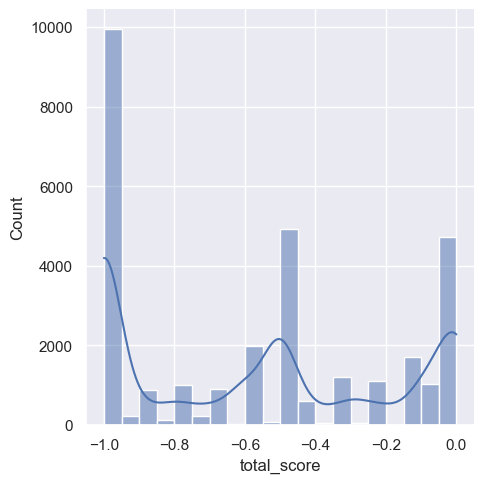

In [28]:
#plot the distribution of total_score
sns.displot(sidewalk_score['total_score'], bins=20, kde=True)

In [29]:
sidewalk_score_map = sidewalk_score.explore(column='total_score', cmap='RdYlGn',tiles='CartoDB dark_matter',style_kwds=dict(weight=1))
sidewalk_score_map.save('sidewalk_score_map.html')